# Semestrální práce
**Předmět**: Programovací jazyky pro data science - Python a R

**Datum**: ZS 2022/23 (listopad)

**Autoři**: Roman Frič, Jan Koubek

**Abstrakt**: Některé jsou jedlé, jiné jsou jedlé jenom jednou. Na základě odkazovaného datasetu to zjistíme (nebo nám aspoň bude veselo).

**Téma**: Klasifikace jedlosti/jedovatosti hub na základě jiných parametrů.

**Dataset**: https://www.kaggle.com/datasets/uciml/mushroom-classification

In [1]:
# INSTALACE a IMPORTY
%pip install pandas numpy scikit-learn matplotlib
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

Note: you may need to restart the kernel to use updated packages.


In [2]:
# naimportujeme nás dataset rovnou jako data frame
df_orig = pd.read_csv(filepath_or_buffer="mushrooms.csv")

### Popis datasetu
Attribute Information: (classes: edible=e, poisonous=p)

- cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
- cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
- cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
- bruises: bruises=t,no=f
- odor: almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
- gill-attachment: attached=a,descending=d,free=f,notched=n
- gill-spacing: close=c,crowded=w,distant=d
- gill-size: broad=b,narrow=n
- gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
- stalk-shape: enlarging=e,tapering=t
- stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
- stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
- stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
- stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
- veil-type: partial=p,universal=u
- veil-color: brown=n,orange=o,white=w,yellow=y
- ring-number: none=n,one=o,two=t
- ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
- spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
- population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y

### Explorační analýza


In [3]:
df_orig.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [4]:
# počet řádků a sloupců
print("Tvar:", df_orig.shape)
# názvy sloupců
print("Sloupce:", df_orig.columns)

Tvar: (8124, 23)
Sloupce: Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


In [5]:
# zjistíme si poměr hodnot cílového atributu
print(df_orig["class"].value_counts())

e    4208
p    3916
Name: class, dtype: int64


In [6]:
# odebereme si sloupce, který jsou příliš nevyvážený
df_orig = df_orig.drop(columns=['veil-color'])
df_orig = df_orig.drop(columns=['veil-type'])
df_orig = df_orig.drop(columns=['gill-attachment'])

### Předzpracování

**Zadání**: Any two of the following operations are mandatory:

- remove rows based on subsetting
- derive new columns
- use aggregation operators
- treat missing values

Protože sloupce jsou na sobě nezávislé, první bod nelze použít.

In [7]:
# Protože oficiální popis datasetu uvádí, že ve sloupci "stalk-root" může být 
# hodnota "?" (což je příznak toho, že chybí), najdeme všechny odpovídající záznamy:
chybejici = df_orig.loc[df_orig['stalk-root'] == "?"]
print("Starý tvar:", df_orig.shape)
print("Tvar chybějících:", chybejici.shape)
# Můžeme ty řádky sice všechny smazat, ale tím se zbavíme 2480 záznamů (z 8123).
# Proto radši smažeme celý sloupec "stalk-root" (a dočasně ho pojmenujeme jinak).
df = df_orig.drop(columns=['stalk-root'])
print("Nový tvar je:", df.shape, "\nSloupce jsou nově:", df.columns)
# Poznámka: další chybějící hodnoty zde už nejsou.

Starý tvar: (8124, 20)
Tvar chybějících: (2480, 20)
Nový tvar je: (8124, 19) 
Sloupce jsou nově: Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
       'stalk-surface-above-ring', 'stalk-surface-below-ring',
       'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')


In [8]:
# Provedeme odvození dalšího sloupce:
# "ring-number" má hodnoty (None, One, Two), které si rovnou převedeme na čísla.
nove_hodnoty_ring_number = {"n":0, "o": 1, "t": 2}
df["number_of_rings"] = df["ring-number"].map(nove_hodnoty_ring_number)

### Vytváření modelu

**Zadání**: Use any classifier. Choose one of the following two options:

- perform train/test split
- use crossvalidation

Also, evaluate and compare at least two algorithms of different types (e.g. logistic regression and random forest).

In [9]:
# Rozhodli jsme se jako první klasifikátor vybrat Rozhodovací stromy.
# Jsou intuitivní a dají se dobře interpretovat.

# Jako druhý klasifikátor použijeme logistickou regresi, ta ale 
# požaduje numerické atributy. Proto si v dalším kroku musíme data upravit.

In [10]:
# Úprava dat.
df['class'] = df['class'].map({'p':1,'e':0})
# V get_dummies nás zajímají všechny sloupce kromě prvního a posledního (ten byl přidán extra):
df = pd.get_dummies(df, df.iloc[:,1:-1].columns, drop_first=True)

In [11]:
# Inicializace klasifikátorů:
dectree = DecisionTreeClassifier(random_state=1054)
logreg = LogisticRegression(random_state=1054)

# Nastavení cíle:
df["class"] = LabelEncoder().fit_transform(df["class"])

# Přepříprava dat:
X = df[:-500].drop('class', axis=1).values
y = df[:-500]['class'].values
# Protože ale nemáme druhý takový dataset, vezmeme pro účely evaluace
# posledních 500 záznamů
X_eval = df[-500:].drop('class', axis=1).values
y_eval = df[-500:]['class'].values

print("Velikost evaluační části, která bude ponechána na konec:",X_eval.shape)

Velikost evaluační části, která bude ponechána na konec: (500, 88)


In [12]:
# Klasifikátory ("Here the magic!"):
dectree.fit(X, y)
logreg.fit(X, y)

LogisticRegression(random_state=1054)

### Ladění metaparametrů

**Zadání**: If the chosen classifier has any metaparameters that can be tuned, use one of the following methods:

- try several configurations and describe the best result in the final report
- perform grid search or other similar automatic method
- once you have tuned metaparameters on a dedicated development (training) set, e.g. with GridSearchCV, you can retrain the model on the complete training data, as e.g. described here for Python: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html and https://stackoverflow.com/questions/26962050/confused-with-repect-to-working-of-gridsearchcv

Python recommendation: sklearn.model_selection.GridSearchCV

In [13]:
# Ladění hyperparametrů
c_space = np.logspace(-5, 8, 15)
params_lorgreg = {'C': c_space}

params_dectree = {"max_depth": range(1,10),
              "max_features": range(1,10),
              "min_samples_leaf": range(1,10),
              "criterion": ["gini", "entropy"]}


dectree_cv = GridSearchCV(dectree, params_dectree, cv=5)
logreg_cv = GridSearchCV(logreg, params_lorgreg, cv=5)

dectree_cv.fit(X_eval,y_eval)
logreg_cv.fit(X_eval,y_eval)

print("Nejlepší parametry rozhodovacích stromů:",dectree_cv.best_params_)
print("Nejlepší parametry logistické regrese:",logreg_cv.best_params_)

Nejlepší parametry rozhodovacích stromů: {'criterion': 'gini', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 1}
Nejlepší parametry logistické regrese: {'C': 0.0007196856730011522}


### Evaluace

**Zadání**: 
- report the accuracy on test set/crossvalidation
- if you are performing binary classification task, involve also the ROC curve
- make sure to use dedicated dataset for evaluation

Python: use model_selection.cross_val_score, plot the roc curve using sklearn.metrics.roc_curve

In [14]:
# Vypíšeme výsledky v křížové validaci (pro oba natrénované modely):
cv_scores_dectree = cross_val_score(dectree, X, y, cv=5, scoring='roc_auc')
cv_scores_logreg = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print("Skóre pro Rozhodovací stromy:", cv_scores_dectree)
print("Skóre pro Logistickou regresi:", cv_scores_logreg)

# Uděláme si z toho přece jen nakonec rozdělení na train/test
X_train, X_test, y_train, y_test = train_test_split(X_eval, y_eval, test_size=0.4, random_state=1054)

Skóre pro Rozhodovací stromy: [0.82513661 1.         1.         1.         0.71815889]
Skóre pro Logistickou regresi: [0.99744348 1.         0.99987078 1.         0.94922397]


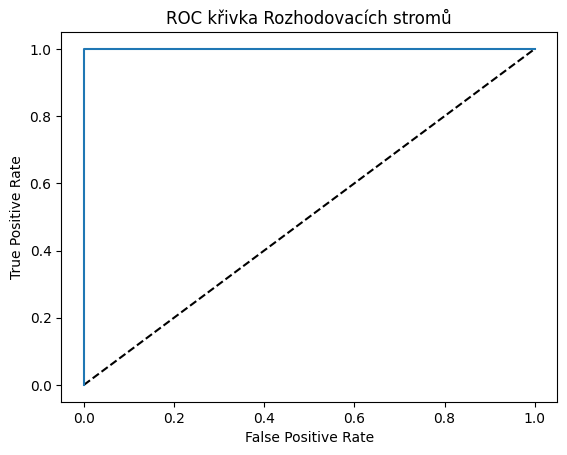

In [15]:
# Vykreslíme graf naší ROC křivky pro rozhodovací stromy
y_pred_prob_dectree = dectree.predict_proba(X_test)[:,1]
fpr_dectree, tpr_dectree, thresholds_dectree = roc_curve(y_test, y_pred_prob_dectree)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dectree, tpr_dectree, label='Rozhodovací stromy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC křivka Rozhodovacích stromů')
plt.show();

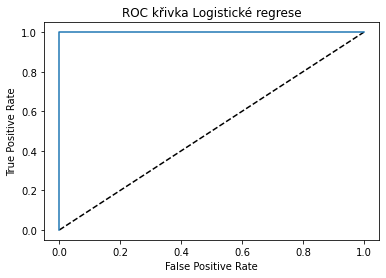

In [15]:
# Vykreslíme graf naší ROC křivky pro logistickou regresi
y_pred_prob_logreg = logreg.predict_proba(X_test)[:,1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_prob_logreg)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_logreg, tpr_logreg, label='Logistická regrese')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC křivka Logistické regrese')
plt.show();

### Interpretace výsledků

Rozhodovací stromy měly sice třikrát stoprocentní úspěšnost, ale jednou ani ne 72%.

Logistická regrese se naopak držela vždy nad 94%, takže dávala mnohem stabilnější výsledky.

Oba klasifikátory jsou ale na první pohled příliš přesné. K přetrénování ale nedošlo, tyto výsledky jsou v pořádku, protože je takto dataset vymyšlen. Jde o treninkový dataset. Pokud by tomu tak nebylo, zřejmě by šlo o problém overfittingu.

In [16]:
# Letmý pohled neukazuje nějakou výraznou korelaci některých atributů (sloupců) s cílovým atributem
df_orig.head(n=15)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,c,n,k,e,e,s,s,w,w,o,p,k,s,u
1,e,x,s,y,t,a,c,b,k,e,c,s,s,w,w,o,p,n,n,g
2,e,b,s,w,t,l,c,b,n,e,c,s,s,w,w,o,p,n,n,m
3,p,x,y,w,t,p,c,n,n,e,e,s,s,w,w,o,p,k,s,u
4,e,x,s,g,f,n,w,b,k,t,e,s,s,w,w,o,e,n,a,g
5,e,x,y,y,t,a,c,b,n,e,c,s,s,w,w,o,p,k,n,g
6,e,b,s,w,t,a,c,b,g,e,c,s,s,w,w,o,p,k,n,m
7,e,b,y,w,t,l,c,b,n,e,c,s,s,w,w,o,p,n,s,m
8,p,x,y,w,t,p,c,n,p,e,e,s,s,w,w,o,p,k,v,g
9,e,b,s,y,t,a,c,b,g,e,c,s,s,w,w,o,p,k,s,m


In [17]:
# Pohled na důležitost jenotlivých "features" (sloupce, které byly použity pro rozhodování) nám ukáže, že
# většinu sloupců rozhodovací strom ani nepoužil:
print(dectree_cv.estimator.feature_importances_.view())
# Jsou však dva atributy, které rozhodovací strom použil a měly více než 50% význam.

[0.00000000e+00 5.24376880e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.09419706e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.74262917e-01 0.00000000e+00
 6.82518318e-02 0.00000000e+00 0.00000000e+00 5.97316590e-01
 1.01922736e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.61619760e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.47312800e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

### Závěr
Vytváření modelů a jejich evaluace proběhly úspěšně. Formálně jsou všechny náležitosti splněny.